In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fitsio

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim

In [3]:
import tqdm

def _get_fwhm_g1g2(psf_im):
    mom = galsim.hsm.FindAdaptiveMom(psf_im)
    return (
        mom.moments_sigma * psf_im.scale * 2.355, 
        mom.observed_shape.g1, 
        mom.observed_shape.g2)


def _measure_atm(ims, scale):
    n = ims.shape[0]
    fwhms = np.zeros((n, n))
    g1 = np.zeros_like(fwhms)
    g2 = np.zeros_like(fwhms)
    for i in tqdm.trange(n):
        for j in range(n):
            psf_im = galsim.ImageD(ims[j, i], scale=scale)
            res = _get_fwhm_g1g2(psf_im)
            fwhms[j, i] = res[0]
            g1[j, i] = res[1]
            g2[j, i] = res[2]
    return fwhms, g1, g2

In [4]:
from mdetsims.real_psf import RealPSF

d = RealPSF('test_seed10_n1e8_lhs256.fits')

 10%|█         | 5/50 [00:01<00:11,  3.76it/s]/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.5       , -6.15451801]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)
100%|██████████| 50/50 [00:06<00:00,  7.46it/s]


In [5]:
def _make_pca_image(_x, _y):
    return d.getPSF(galsim.PositionD(x=_x, y=_y)).image.array

ims = np.zeros((225, 225, 17, 17))
for y in tqdm.trange(0, 225):
    for x in range(0, 225):
        ims[y, x] = _make_pca_image(x, y)

100%|██████████| 225/225 [07:13<00:00,  1.69s/it]


In [6]:
fwhms, g1, g2 = _measure_atm(ims, 0.263)

100%|██████████| 225/225 [00:20<00:00, 10.83it/s]


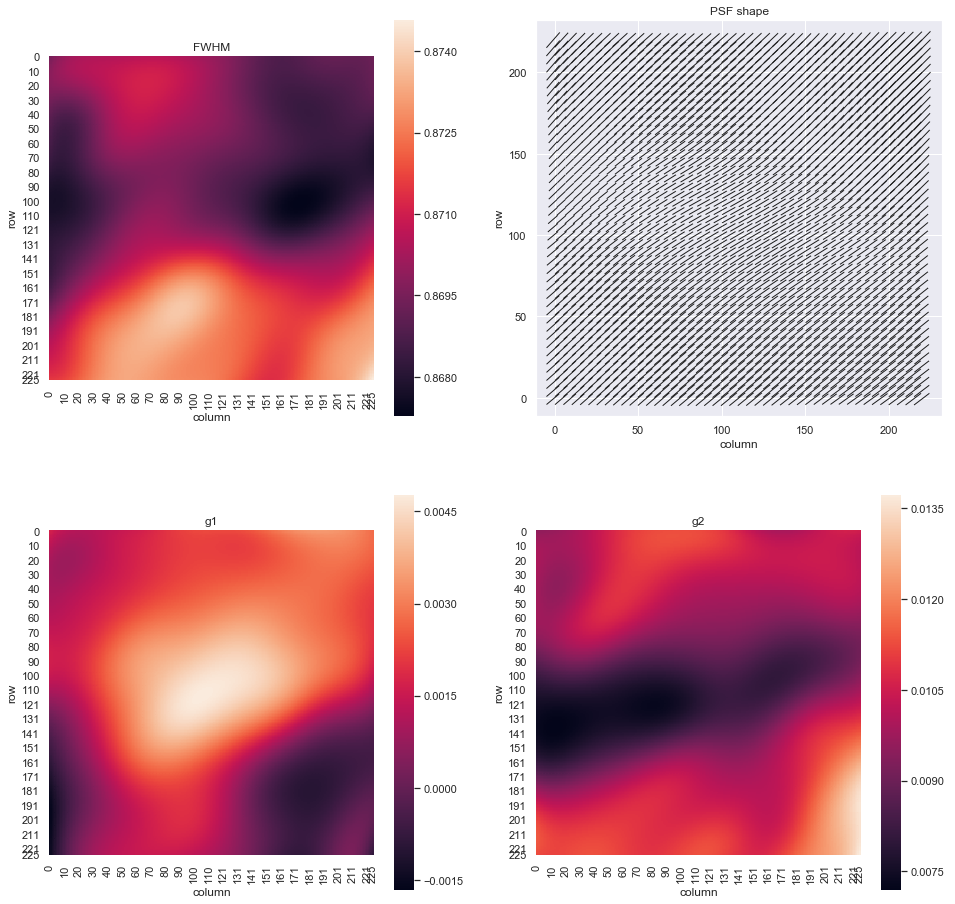

In [7]:
from mdetsims.plots import plot_psf_model

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
plot_psf_model(fwhms, g1, g2, ims.shape[0], axs)

  2%|▏         | 1/50 [00:01<01:00,  1.24s/it]/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 10.15185547, -15.58735085]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
 28%|██▊       | 14/50 [00:17<00:37,  1.03s/it]/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.26370388e+01, -2.25962107e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
 42%|████▏     | 21/50 [00:24<00:26,  1.12it/s]/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.81607695e+00, -1.2611

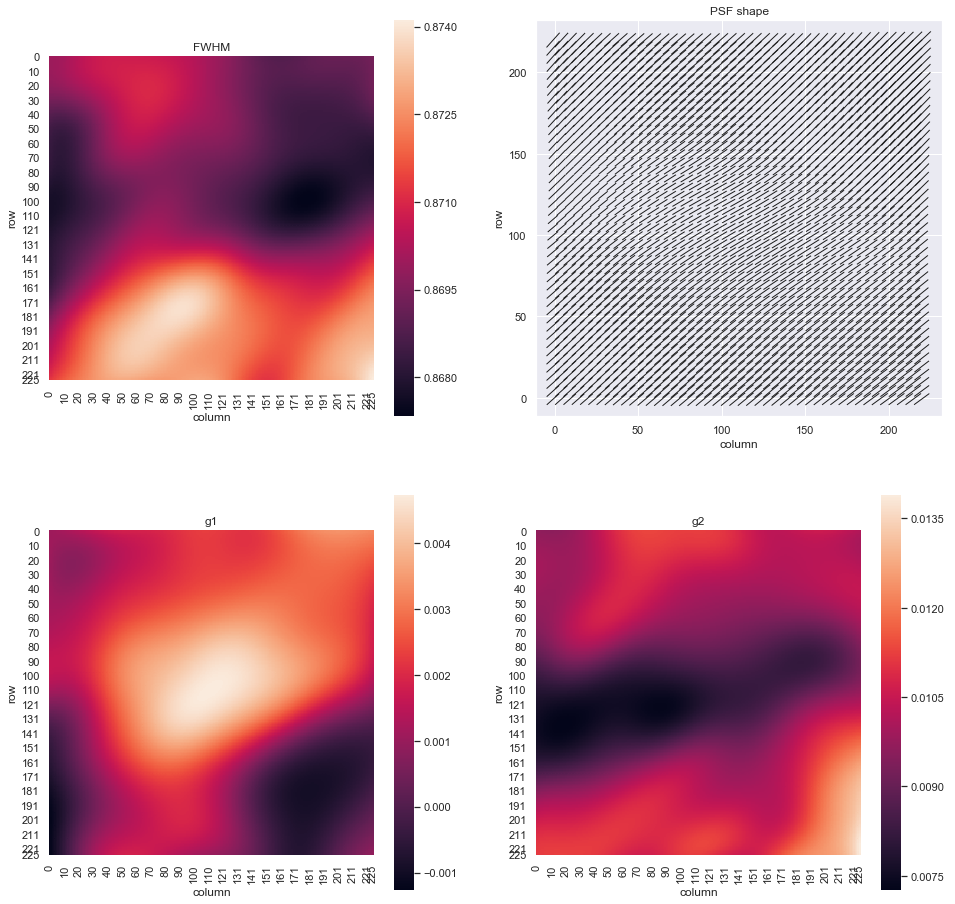

In [8]:
d = RealPSF('test_seed10_n1e8_lhs512.fits')

def _make_pca_image(_x, _y):
    return d.getPSF(galsim.PositionD(x=_x, y=_y)).image.array

ims = np.zeros((225, 225, 17, 17))
for y in tqdm.trange(0, 225):
    for x in range(0, 225):
        ims[y, x] = _make_pca_image(x, y)

fwhms, g1, g2 = _measure_atm(ims, 0.263)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
plot_psf_model(fwhms, g1, g2, ims.shape[0], axs)

In [ ]:
import treecorr

y, x = np.mgrid[:225, :225] * 0.263
cat = treecorr.Catalog(
    x=y.ravel(), y=x.ravel(), g1=g1.ravel(), g2=g2.ravel(),
    x_units='arcsec', y_units='arcsec')

gg = treecorr.GGCorrelation(
    nbins=50, min_sep=1, max_sep=60, bin_slop=0.1,
    sep_units='arcsec')

gg.process_auto(cat)
gg.finalize(np.std(g1)**2, np.std(g2)**2)

Text(0.5, 1.0, 'DES-like PSF 90 seconds')

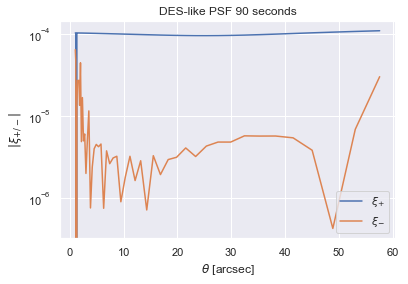

In [16]:
plt.figure()
plt.semilogy(gg.rnom, np.abs(gg.xip), label=r'$\xi_{+}$')
plt.semilogy(gg.rnom, np.abs(gg.xim), label=r'$\xi_{-}$')
plt.xlabel(r'$\theta$ [arcsec]')
plt.ylabel(r'$|\xi_{+/-}|$')
plt.legend(loc=4)
plt.title('DES-like PSF 90 seconds')

In [ ]:
d8 = RealPSF('test_seed10_n1e8_lhs512.fits')
d9 = RealPSF('test_seed10_n1e9_lhs64.fits')

In [ ]:
ind = 10

print(d8.psf_locs[ind], d9.psf_locs[ind])

plt.figure(figsize=(10, 10))
sns.heatmap(
    (d8.psf_images[ind, :, :] - d9.psf_images[ind, :, :])/np.max(d9.psf_images[ind, :, :]), 
    square=True)

In [ ]:
def _get_s2n(im):
    nse = np.std(im[:, 0].tolist() + im[:, -1].tolist())
    s2n = np.sqrt(np.sum(im**2)) / nse
    return s2n

print('1e8:', _get_s2n(d8.psf_images[ind, :, :]))
print('1e9:', _get_s2n(d9.psf_images[ind, :, :]))

In [ ]:
from mdetsims.real_psf import RealPSFGenerator
import galsim

In [ ]:
r = RealPSFGenerator(seed=10, scale=0.263, im_width=225, n_photons=1e6) 

In [ ]:
im1010 = np.zeros((17, 17))
for _ in tqdm.trange(10):
    im1010 += r.getPSF(galsim.PositionD(x=10, y=10)).drawImage(
        nx=r.psf_width,
        ny=r.psf_width,
        scale=r.scale,
        method='phot',
        n_photons=r.n_photons,).array

In [ ]:
im1011 = np.zeros((17, 17))
for _ in tqdm.trange(100):
    im1011 += r.getPSF(galsim.PositionD(x=10, y=11)).drawImage(
        nx=r.psf_width,
        ny=r.psf_width,
        scale=r.scale,
        method='phot',
        n_photons=r.n_photons,).array

In [ ]:
im1015 = np.zeros((17, 17))
for _ in tqdm.trange(100):
    im1015 += r.getPSF(galsim.PositionD(x=10, y=15)).drawImage(
        nx=r.psf_width,
        ny=r.psf_width,
        scale=r.scale,
        method='phot',
        n_photons=1e6).array

In [ ]:
print(_get_fwhm_g1g2(galsim.ImageD(im1010, scale=0.263)))
print(_get_fwhm_g1g2(galsim.ImageD(im1011, scale=0.263)))
print(_get_fwhm_g1g2(galsim.ImageD(im1015, scale=0.263)))

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap((im1010 - im1015)/np.max(im1011), square=True)